### Figure generation notebook for MERFISH single cell quality control

In [58]:
import os
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
import numpy as np
from scipy.sparse import csr_matrix
from scipy.stats import ks_2samp
import anndata
import scanpy
import string
import seaborn as sns
import h5py
import tifffile
import fs
from fs import open_fs
from matplotlib_scalebar.scalebar import ScaleBar
from merlin.core import dataset


mpl.rcParams.update(mpl.rcParamsDefault) #Reset rcParams to default
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Colors in this style

# Plotting style function (run this before plotting the final figure)
def set_plotting_style():
    plt.style.use('seaborn-paper')
    plt.rc('axes', labelsize=12)
    plt.rc('axes', titlesize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('legend', fontsize=10)
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('xtick.major', pad=2)
    plt.rc('ytick.major', pad=2)
    plt.rc('mathtext', fontset='stixsans', sf='sansserif')
    plt.rc('figure', figsize=[10,9])
    plt.rc('svg', fonttype='none')
    
# Function for plotting DAPI mosaic, segmentation, and transcript locations
# Returns cropped mosaic, cell boundaries, filtering status, and transcripts for a specific field of view

def plot_overlay(fov, cellMetadata, cellByGene, dapi_mosaic, 
                 transformation_matrix, cell_boundaries, detectedTranscripts, QCFilter, zInd):
    
    # Get the QC filtering metrics
    min_volume = QCFilter['min_cell_volume']
    max_volume = QCFilter['max_cell_volume']
    min_counts = QCFilter['min_transcript_count']
    min_dapi = QCFilter['min_dapi_score']
    
    # Get the boundary segmentation coordinates
    current_cells = []
    current_cells_filter = []
    for i in cellMetadata[cellMetadata['fov'] == fov].index:
        if i in cell_boundaries['featuredata'] and 'p_0' in cell_boundaries['featuredata'][i]['zIndex_%i' % zInd]:
            # Get the boundary for this cell
            temp = np.array(cell_boundaries['featuredata'][i]['zIndex_%i' % zInd]['p_0']['coordinates'][0])
            boundary_polygon = np.ones((temp.shape[0], temp.shape[1]+1))
            boundary_polygon[:, :-1] = temp
            transformed_boundary = np.matmul(transformation_matrix, np.transpose(boundary_polygon))[:-1]
            current_cells.append(transformed_boundary)
            
            # Save the filtering status for this cell
            if cellMetadata.loc[i,'volume'] < min_volume or cellMetadata.loc[i,'volume'] > max_volume \
            or cellByGene.loc[i,:].sum() < min_counts or cellMetadata.loc[i,'median average DAPI'] < min_dapi:
                current_cells_filter.append(0)
            else:
                current_cells_filter.append(1)

    min_coord = np.min([np.min(x, axis=1) for x in current_cells], axis=0).astype(int)
    max_coord = np.max([np.max(x, axis=1) for x in current_cells], axis=0).astype(int)   

    # Get transcript positions
    active_transcripts = detectedTranscripts[detectedTranscripts['fov'] == fov].copy()
    temp = active_transcripts[['global_y', 'global_x']].values
    transcript_positions = np.ones((temp.shape[0], temp.shape[1]+1))
    transcript_positions[:, :-1] = temp
    transformed_positions = np.matmul(transformation_matrix, np.transpose(transcript_positions))[:-1]
    active_transcripts.loc[:, 'local_x'] = transformed_positions[0, :]
    active_transcripts.loc[:,'local_y'] = transformed_positions[1, :]

    # Return variables for plotting
    dapi_mosaic = dapi_mosaic[min_coord[1]:max_coord[1], min_coord[0]:max_coord[0]]
    for i in range(len(current_cells)):
        current_cells[i][0] = current_cells[i][0] - min_coord[0]
        current_cells[i][1] = current_cells[i][1] - min_coord[1]

    active_transcripts['local_y'] = active_transcripts['local_y'] - min_coord[0]
    active_transcripts['local_x'] = active_transcripts['local_x'] - min_coord[1]

    return dapi_mosaic, current_cells, current_cells_filter, active_transcripts

# Function to plot overlay using local FOV information
def plot_overlay_local(fov, cellMetadata, cellByGene, globalAlignment, transformationMatrix,
                 fiducialCorrelationWarp, cell_boundaries, detectedTranscripts, QCFilter, zInd, dapiCh):
    
    # Get the QC filtering metrics
    min_volume = QCFilter['min_cell_volume']
    max_volume = QCFilter['max_cell_volume']
    min_counts = QCFilter['min_transcript_count']
    min_dapi = QCFilter['min_dapi_score']

    # Get the boundary segmentation coordinates
    current_cells = []
    current_cells_filter = []
    for i in cellMetadata[cellMetadata['fov'] == fov].index:
        if i in cell_boundaries['featuredata'] and 'p_0' in cell_boundaries['featuredata'][i]['zIndex_%i' % zInd]:
            # Get the boundary for this cell
            temp = np.array(cell_boundaries['featuredata'][i]['zIndex_%i' % zInd]['p_0']['coordinates'][0])
            boundary_polygon = np.ones((temp.shape[0], temp.shape[1]+1))
            boundary_polygon[:, :-1] = temp
            transformed_boundary = np.matmul(transformationMatrix, np.transpose(boundary_polygon))[:-1]
            current_cells.append(transformed_boundary)
            
            # Save the filtering status for this cell
            if cellMetadata.loc[i,'volume'] < min_volume or cellMetadata.loc[i,'volume'] > max_volume \
            or cellByGene.loc[i,:].sum() < min_counts or cellMetadata.loc[i,'median average DAPI'] < min_dapi:
                current_cells_filter.append(0)
            else:
                current_cells_filter.append(1)
    
    # Positions of decoded transcripts + segmented boundaries
    active_transcripts = detectedTranscripts[detectedTranscripts['fov'] == fov].copy()
    active_transcripts['local_y'] = active_transcripts['y']
    active_transcripts['local_x'] = active_transcripts['x']
    
    # Dapi channel
    dapi_im = fiducialCorrelationWarp.get_aligned_image(fov, dapiCh, zInd)

    return dapi_im, current_cells, current_cells_filter, active_transcripts

In [59]:
# Load raw MERFISH results
# Define the path of the analyzed data

dataPath = '/mnt/ibm_lg/spatial-seq/MERlin_Analysis'

# Define the experiments

experimentName = ['MsLiver_Cellbound_VZG116_V1_JH_09-18-2021', 
                  'MsKidney_CellBoundary_VZG116_111921']
detectedTranscripts = []
cellMetadata = []
cellByGene = []
transformationMatrix = []

for i in range(len(experimentName)):
    # Decoded transcripts
    detectedTranscripts.append(pd.read_csv(os.path.join(
        dataPath, experimentName[i], 'ExportBarcodes', 'region_0', 'barcodes.csv')))

    # Cell segmentation metadata
    cellMetadata.append(pd.read_csv(os.path.join(
        dataPath, experimentName[i], 'ExportCellMetadata', 'region_0','feature_metadata_augmented.csv'), index_col=0))

    # Counts per segmented cell
    cellByGene.append(pd.read_csv(os.path.join(
        dataPath, experimentName[i], 'ExportPartitionedBarcodes', 'region_0', 'barcodes_per_feature.csv'), index_col=0))
    
    # Transformation matrix
    #transformationMatrix.append(np.loadtxt(
    #os.path.join(dataPath, experimentName[i], "BlendMosaic", "region_0", 'micron_to_mosaic_pixel_transform.csv')))

print('Datasets loaded.')

Datasets loaded.


In [60]:
# Load postprocessed MERFISH and MACA results

# Define the path of the analyzed MERFISH data
dataPathPost = '/mnt/ibm_lg/spatial-seq/MERlin_Analysis/ProcessedResults'

# Define the experiment
prefixCounts = 'RawCounts'
prefixCountsFilter = 'FilteredCounts'
suffixCounts = '_RawSingleCellCounts.h5ad'
suffixCountsFilter = '_FilteredSingleCellCounts.h5ad'

VizgenCounts = []
VizgenCountsFilter = []
QCFilter = []
for i in range(len(experimentName)):
    # Raw counts per segmented cell
    VizgenCounts.append(
        anndata.read_h5ad(os.path.join(dataPathPost, prefixCounts, experimentName[i] + suffixCounts)))

    # Filtered counts per segmented cell
    VizgenCountsFilter.append(anndata.read_h5ad(os.path.join(dataPathPost, prefixCountsFilter, 
                                                        experimentName[i] + suffixCountsFilter)))

    # Get filtering criteria
    QCFilter.append(VizgenCountsFilter[i].uns['QC_filter'])
    
print('Processed data loaded.')

Processed data loaded.


In [61]:
# # Load DAPI mosaics
# dapiMosaic = []
# zInd = 3
# z_stack = ['z0','z1','z2','z3','z4','z5','z6']

# for i in range(len(experimentName)):
#     dapiMosaic.append(tifffile.TiffFile(os.path.join(
#         dataPath, experimentName[i], "BlendMosaic", "region_0" , 'mosaic_DAPI_' + z_stack[zInd] + '.tif')).asarray())

# print('Mosaics loaded.')

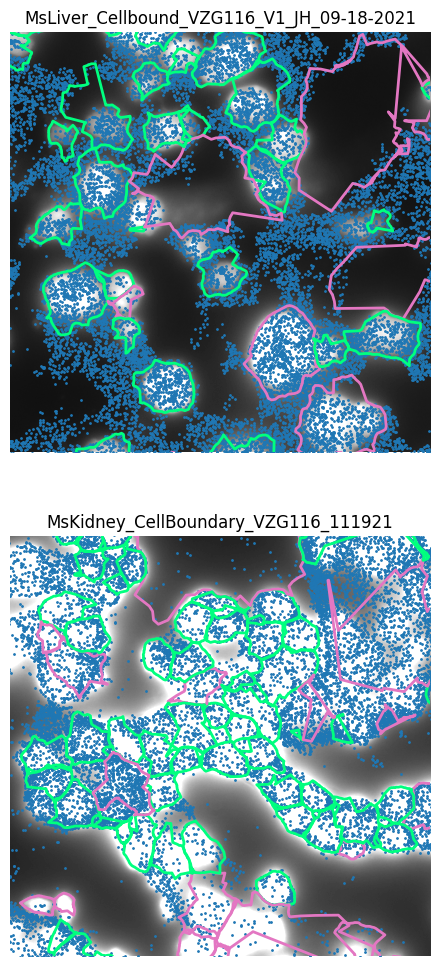

In [62]:
# Plot the image overlay using the DAPI mosaic

fov = [29,30]
minX = 200
maxX = 1200
minY = 500
maxY = 1500
zInd = 3
dapiCh = 28
cellBoundaries = []
dapiImPlot = []
currentCells = []
currentCellsFilter = []
activeTranscripts = []
globalAlignment = []
fiducialCorrelationWarp = []
transformationMatrix = []

for j in range(len(experimentName)):
    # Load MERlin tasks
    d_set = dataset.MERFISHDataSet(experimentName[j])
    globalAlignment.append(d_set.load_analysis_task('CorrelationGlobalAlignment'))
    fiducialCorrelationWarp.append(d_set.load_analysis_task('FiducialCorrelationWarp'))
    transformationMatrix.append(np.linalg.inv(globalAlignment[j].fov_to_global_transform(fov[j])))
    
    # Get cell boundaries
    cellBoundaries.append(h5py.File(os.path.join(dataPath, experimentName[j], \
                                             'RefineCellDatabases', 'features', \
                                             'feature_data_%i.hdf5' % fov[j]), 'r'))

    size_of_one_pixel = 1 / transformationMatrix[j][0,0]

    dapi_im_plot, current_cells, current_cells_filter, active_transcripts = plot_overlay_local(
        fov[j], cellMetadata[j], cellByGene[j], globalAlignment[j], transformationMatrix[j],
        fiducialCorrelationWarp[j], cellBoundaries[j], detectedTranscripts[j], QCFilter[j], zInd, dapiCh)
    
    dapiImPlot.append(dapi_im_plot)
    currentCells.append(current_cells)
    currentCellsFilter.append(current_cells_filter)
    activeTranscripts.append(active_transcripts)

# Plot DAPI + transcripts + boundaries
fig, ax = plt.subplots(2,1,figsize=(24,12))

for j in range(len(experimentName)):
    ax[j].imshow(dapiImPlot[j], 
              vmin=0, vmax=10000, cmap=plt.cm.gray)

    ax[j].scatter(activeTranscripts[j]['local_x'], activeTranscripts[j]['local_y'],  
                    c='tab:blue', cmap='Accent', s=1)

    for i in range(len(currentCells[j])): # Plot cell boundaries
        if currentCellsFilter[j][i] == 0:
            ax[j].plot(currentCells[j][i][0], currentCells[j][i][1],
                    color='tab:pink', linestyle='-', linewidth=2)
        elif currentCellsFilter[j][i] == 1:
            ax[j].plot(currentCells[j][i][0], currentCells[j][i][1],
                    color='springgreen', linestyle='-', linewidth=2)

    ax[j].set_xlim(minX, maxX)
    ax[j].set_ylim(minY, maxY)

    ax[j].set_title(experimentName[j])
    ax[j].axis('off')

plt.show()

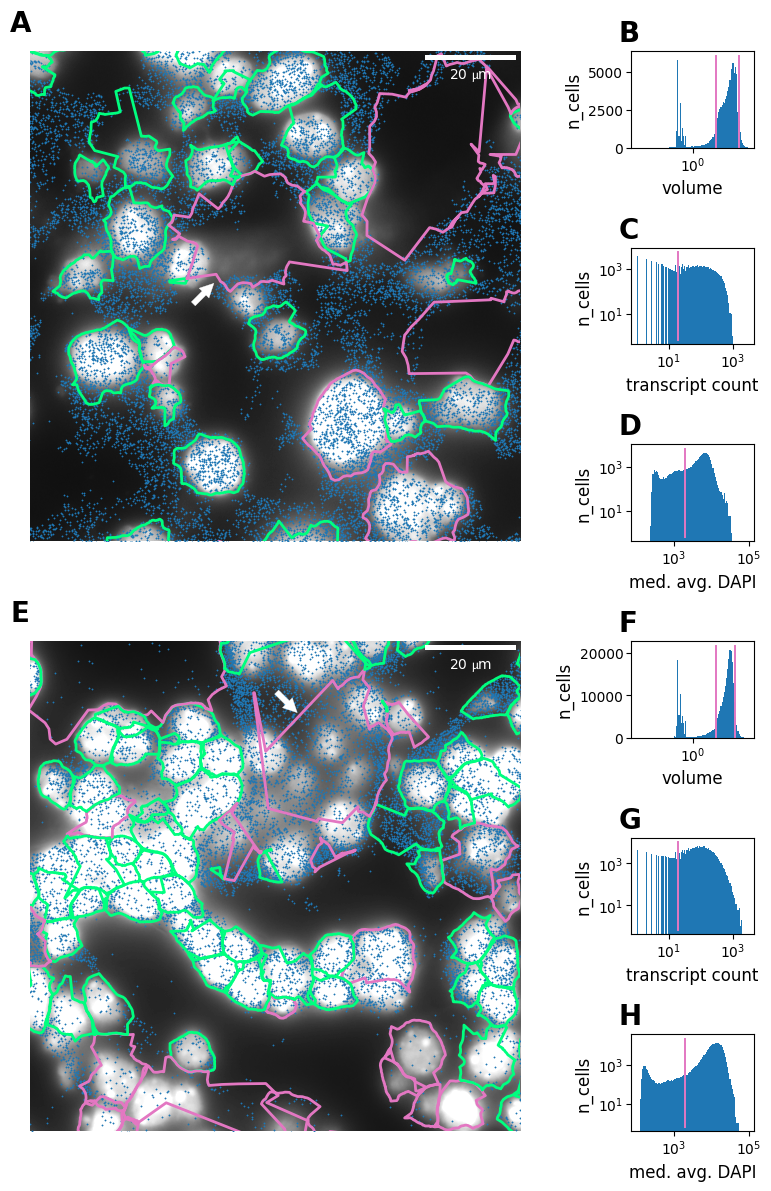

In [77]:
# Plot the whole figure

set_plotting_style()

fig, ax = plt.subplots(ncols=4, nrows=6, figsize=(8,12)) #Create a grid
gs = ax[0,0].get_gridspec() #Get gridspecs

# remove the underlying axes for the image panels
for i in [0,1,2,3,4,5]:
    for j in [0,1,2]:
        ax[i,j].remove()

axbig1 = fig.add_subplot(gs[0:3, 0:3])
axbig2 = fig.add_subplot(gs[3:6, 0:3])

# fig, axs = plt.subplots(nrows=2)
# arrow = mpatches.FancyArrowPatch((x_tail, y_tail), (x_head, y_head),
#                                  mutation_scale=100)
# axs[0].add_patch(arrow)

# arrow = mpatches.FancyArrowPatch((x_tail, y_tail), (x_head, y_head),
#                                  mutation_scale=100)
# axs[1].add_patch(arrow)
# axs[1].set(xlim=(0, 2), ylim=(0, 2))

# Panel A: liver image overlay
j = 0
minX = 200
maxX = 1200
minY = 500
maxY = 1500

min_volume = QCFilter[j]['min_cell_volume']
max_volume = QCFilter[j]['max_cell_volume']
min_counts = QCFilter[j]['min_transcript_count']
min_dapi = QCFilter[j]['min_dapi_score']

axbig1.imshow(dapiImPlot[j], cmap='gray', vmin=0, vmax=10000, origin='lower') # Plot DAPI
axbig1.scatter(activeTranscripts[j]['local_x'], activeTranscripts[j]['local_y'],  
                c='tab:blue', cmap='Accent', s=1) # Transcripts

for i in range(len(currentCells[j])): # Plot cell boundaries
        if currentCellsFilter[j][i] == 0:
            axbig1.plot(currentCells[j][i][0], currentCells[j][i][1],
                    color='tab:pink', linestyle='-', linewidth=2)
        elif currentCellsFilter[j][i] == 1:
            axbig1.plot(currentCells[j][i][0], currentCells[j][i][1],
                    color='springgreen', linestyle='-', linewidth=2)
axbig1.set_xlim(minX, maxX)
axbig1.set_ylim(minY, maxY)
axbig1.axis('off')
scalebar = ScaleBar(size_of_one_pixel, "um", color='w', box_color='w', box_alpha=0)
axbig1.add_artist(scalebar)

# arrow to annotate example of bad segmentation
arrow = mpatches.FancyArrowPatch((530,980), (580,1030), color='w', mutation_scale=20)
axbig1.add_patch(arrow)

# Panel B: histogram of cell volumes
bins = np.logspace(-4,4,100)
ax[0,3].hist(VizgenCounts[j].obs.volume,bins=bins, label='data')
ax[0,3].set_xlabel('volume')
ax[0,3].set_ylabel('n_cells')
ax[0,3].set_xscale('log')
ylim = ax[0,3].get_ylim()
ax[0,3].plot([min_volume, min_volume],ylim, '-', color='tab:pink', label='cutoff')
ax[0,3].plot([max_volume, max_volume],ylim, '-', color='tab:pink')
#ax[0,3].legend()

# Panel C: Vizgen histogram of cell counts
bins = np.logspace(0,3.5,100)
ax[1,3].hist(VizgenCounts[j].obs.barcodeCount,bins=bins, label='data')
ax[1,3].set_xlabel('transcript count')
ax[1,3].set_ylabel('n_cells')
ax[1,3].set_xscale('log')
ax[1,3].set_yscale('log')
ax[1,3].plot([min_counts, min_counts], ax[1,3].get_ylim(), '-', color='tab:pink', label='cutoff')
#ax[1,3].legend()

# Panel D: Vizgen histogram of average DAPI intensities
bins = np.logspace(2,5,100)
ax[2,3].hist(VizgenCounts[j].obs['median average DAPI'],bins=bins, label='data')
ax[2,3].set_xlabel('med. avg. DAPI')
ax[2,3].set_ylabel('n_cells')
ax[2,3].set_xscale('log')
ax[2,3].set_yscale('log')
ax[2,3].plot([min_dapi, min_dapi], ax[2,3].get_ylim(), '-', color='tab:pink', label='cutoff')
#ax[2,3].legend()

# Panel E: kidney image overlay
j = 1
minX = 500
maxX = 1500
minY = 500
maxY = 1500

min_volume = QCFilter[j]['min_cell_volume']
max_volume = QCFilter[j]['max_cell_volume']
min_counts = QCFilter[j]['min_transcript_count']
min_dapi = QCFilter[j]['min_dapi_score']

axbig2.imshow(dapiImPlot[j], cmap='gray', vmin=0, vmax=20000, origin='lower') # Plot DAPI
axbig2.scatter(activeTranscripts[j]['local_x'], activeTranscripts[j]['local_y'],  
                c='tab:blue', cmap='Accent', s=1) # Transcripts

for i in range(len(currentCells[j])): # Plot cell boundaries
        if currentCellsFilter[j][i] == 0:
            axbig2.plot(currentCells[j][i][0], currentCells[j][i][1],
                    color='tab:pink', linestyle='-', linewidth=2)
        elif currentCellsFilter[j][i] == 1:
            axbig2.plot(currentCells[j][i][0], currentCells[j][i][1],
                    color='springgreen', linestyle='-', linewidth=2)
axbig2.set_xlim(minX, maxX)
axbig2.set_ylim(minY, maxY)
axbig2.axis('off')
scalebar = ScaleBar(size_of_one_pixel, "um", color='w', box_color='w', box_alpha=0)
axbig2.add_artist(scalebar)

# arrow to annotate example of bad segmentation
arrow = mpatches.FancyArrowPatch((1000, 1400), (1050,1350), color='w', mutation_scale=20)
axbig2.add_patch(arrow)

# Panel F: histogram of cell volumes
bins = np.logspace(-4,4,100)
ax[3,3].hist(VizgenCounts[j].obs.volume,bins=bins, label='data')
ax[3,3].set_xlabel('volume')
ax[3,3].set_ylabel('n_cells')
ax[3,3].set_xscale('log')
ylim = ax[3,3].get_ylim()
ax[3,3].plot([min_volume, min_volume],ylim, '-', color='tab:pink', label='cutoff')
ax[3,3].plot([max_volume, max_volume],ylim, '-', color='tab:pink')
#ax[3,3].legend()

# Panel G: Vizgen histogram of cell counts
bins = np.logspace(0,3.5,100)
ax[4,3].hist(VizgenCounts[j].obs.barcodeCount,bins=bins, label='data')
ax[4,3].set_xlabel('transcript count')
ax[4,3].set_ylabel('n_cells')
ax[4,3].set_xscale('log')
ax[4,3].set_yscale('log')
ax[4,3].plot([min_counts, min_counts], ax[4,3].get_ylim(), '-', color='tab:pink', label='cutoff')
#ax[4,3].legend()

# Panel H: Vizgen histogram of average DAPI intensities
bins = np.logspace(2,5,100)
ax[5,3].hist(VizgenCounts[j].obs['median average DAPI'],bins=bins, label='data')
ax[5,3].set_xlabel('med. avg. DAPI')
ax[5,3].set_ylabel('n_cells')
ax[5,3].set_xscale('log')
ax[5,3].set_yscale('log')
ax[5,3].plot([min_dapi, min_dapi], ax[5,3].get_ylim(), '-', color='tab:pink', label='cutoff')
#ax[5,3].legend()


# Label subpanels
axes = [axbig1, ax[0,3], ax[1,3], ax[2,3], axbig2, ax[3,3], ax[4,3], ax[5,3]]
for n, ax in enumerate(axes):
    if n == 0 or n == 4:
        ax.text(-0.04, 1.04, string.ascii_uppercase[n], transform=ax.transAxes, 
                size=20, weight='bold')
    else:
        ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
                size=20, weight='bold')

fig.tight_layout()
plt.show()

In [87]:
# Export figures
fig.savefig('../../figures/Fig4_singlecellQC.svg', transparent=True)
fig.savefig('../../figures/Fig4_singlecellQC.png', transparent=True)

print('Figures saved.')

Figures saved.


In [95]:
# What was the yield?
# Define the whole set of experiments
experimentName = ['MsLiver_Cellbound_VZG116_V1_JH_09-18-2021', 
                  'MsKidney_CellBoundary_VZG116_111921',
                  'MsKidney_CellBoundary_VZG116_121021']

VizgenCounts = []
VizgenCountsFilter = []
QCFilter = []
for i in range(len(experimentName)):
    # Raw counts per segmented cell
    VizgenCounts.append(
        anndata.read_h5ad(os.path.join(dataPathPost, prefixCounts, experimentName[i] + suffixCounts)))

    # Filtered counts per segmented cell
    VizgenCountsFilter.append(anndata.read_h5ad(os.path.join(dataPathPost, prefixCountsFilter, 
                                                        experimentName[i] + suffixCountsFilter)))

    # Get filtering criteria
    QCFilter.append(VizgenCountsFilter[i].uns['QC_filter'])
    
print('Processed data loaded.')

# Calculate yield and number of cells
n_cells_raw = np.array([len(VizgenCounts[x]) for x in range(len(experimentName))])
n_cells_physical = np.array([len(VizgenCounts[x][VizgenCounts[x].obs['volume'] > 
                                QCFilter[x]['min_cell_volume']]) for x in range(len(experimentName))])
n_cells_filter = np.array([len(VizgenCountsFilter[x]) for x in range(len(experimentName))])
filter_yield = 100 * n_cells_filter / n_cells_raw

print(n_cells_raw)
print(n_cells_physical)
print(n_cells_filter)
print(filter_yield)

# Overall yield and number of cells
print('Overall number of liver cells: ' + str(n_cells_raw[0]) + ' raw, ' + str(n_cells_filter[0]) + ' filtered.')
print('Overall number of kidney cells: ' + str(n_cells_raw[1] + n_cells_raw[2]) + ' raw, ' + 
     str(n_cells_filter[1] + n_cells_filter[2]) + ' filtered.')

Processed data loaded.
[ 98317 285031 223321]
[ 76034 208097 161407]
[ 36254 149665  60883]
[36.87459951 52.50832366 27.26255032]
Overall number of liver cells: 98317 raw, 36254 filtered.
Overall number of kidney cells: 508352 raw, 210548 filtered.


In [90]:
n_cells_raw

array([ 98317, 285031, 223321])

In [91]:
n_cells_physical

array([ 98317, 285031, 223321])